In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import pandas as pd

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 300x300 images with random horizontal flip, random rotation and normalization

In [2]:
dataset_dir = "../input/car_data/car_data/"

train_transform = transforms.Compose([transforms.Resize((300, 300)),
                                 transforms.RandomRotation(15),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transform = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_transform)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


## Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [3]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        counter = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            # Assign data to CUDA if available
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            counter += len(inputs)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels) # We need to give the original propabilities instead of the final labels.
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss / counter
        print(running_correct, counter)
        epoch_acc = 100 * (running_correct / counter)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        scheduler.step(epoch_acc)
        since = time.time()
    print('Finished Training')
    
    return model, losses, accuracies

### Evaluate on testing data
This function is called out after training on the training data. We then measure the accuracy of the model.

In [4]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * (correct / total)
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [6]:
model_ft = models.densenet161(pretrained=True)

In [8]:

num_ftrs = model_ft.classifier.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.classifier = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [10]:
model_ft, training_losses, training_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

1944.0 8144
Epoch 1, duration: 191 s, loss: 0.1093, acc: 23.8703
5651.0 8144
Epoch 2, duration: 189 s, loss: 0.0360, acc: 69.3885
6968.0 8144
Epoch 3, duration: 189 s, loss: 0.0170, acc: 85.5599
7510.0 8144
Epoch 4, duration: 189 s, loss: 0.0097, acc: 92.2151
7763.0 8144
Epoch 5, duration: 190 s, loss: 0.0058, acc: 95.3217
7915.0 8144
Epoch 6, duration: 189 s, loss: 0.0036, acc: 97.1881
8049.0 8144
Epoch 7, duration: 189 s, loss: 0.0019, acc: 98.8335
8093.0 8144
Epoch 8, duration: 189 s, loss: 0.0012, acc: 99.3738
8106.0 8144
Epoch 9, duration: 189 s, loss: 0.0011, acc: 99.5334
8109.0 8144
Epoch 10, duration: 189 s, loss: 0.0010, acc: 99.5702
Finished Training


In [11]:
torch.save(model_ft.state_dict(), './AlexNetFineTurning')

### As we can see the model reached 90% training accuracy by epoch 10.


In [12]:
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [13]:
eval_model(model_ft)

Accuracy of the network on the test images: 91 %


91.60552170128094

### View the missclassified Images

In [14]:
import pandas as pd

names = list(pd.read_csv("../input/names.csv", names = ['names'])['names'])

In [15]:
from matplotlib.pyplot import figure

def getMisclassifiedImages(model):
    count = 0
    with torch.no_grad():
        fig = figure(figsize=(10, 10))
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(0, len(predicted)):
                if (predicted[i] != labels[i]):
                    img = images[i].cpu().numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    plt.subplot(3, 2 , count + 1)
                    plt.tight_layout()
                    plt.title("Predicted : " + str(names[predicted[i]]) + "\n" + "Actual : " + str(names[labels[i]]) + "\n")
                    plt.imshow((img * 255).astype(np.uint8))
                    plt.axis("off")
                    count += 1
                    if (count == 6):
                        break
            if (count == 6):
                break

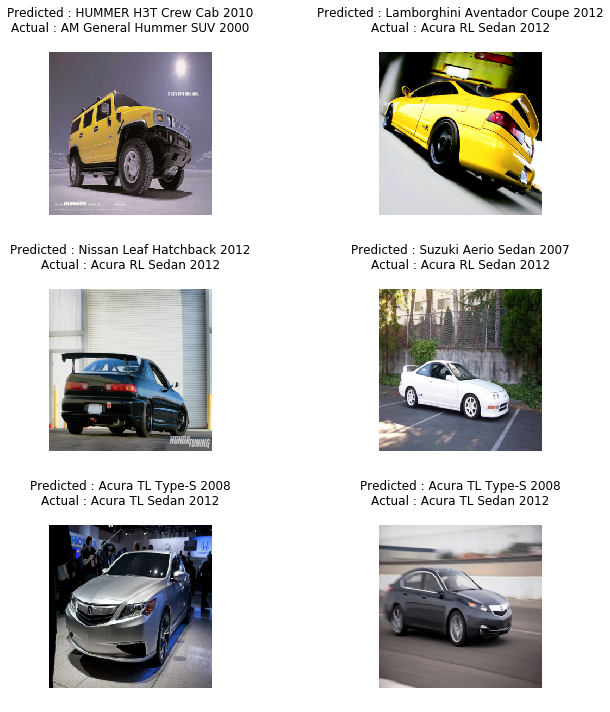

In [16]:
getMisclassifiedImages(model_ft)